In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
from fastai import *

In [2]:
from pathlib import Path

In [3]:
torch.cuda.set_device(0)

In [4]:
DATA_PATH = Path('data/comments/')
TEST_CSV = DATA_PATH/'test.csv'
TRAIN_CSV = DATA_PATH/'train.csv'
TRAIN_LABELS_CSV = DATA_PATH/'test_labels.csv'

## Loading Data

In [5]:
chunksize = 24000

In [6]:
CLAS_PATH=Path('data/comment_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/comment_lm/')
LM_PATH.mkdir(exist_ok=True)

In [7]:
test = pd.read_csv(TEST_CSV)
test_labels = pd.read_csv(TRAIN_LABELS_CSV)
train = pd.read_csv(TRAIN_CSV, chunksize=chunksize, header='infer')

In [8]:
test_combined = pd.merge(
    test, test_labels
)

In [9]:
test_combined.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [10]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

## Configuring Training Data

In [11]:
rel = re.compile(r'  +')
def fixup(x: str):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return rel.sub(' ', x)

In [12]:
BOS = 'xbos'
FLD = 'xfld'

In [13]:
def get_texts(row):
    labels = row[list_classes].values
    texts = f'\n{BOS} {FLD} 1 ' + row['comment_text'].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return list(tok), list(labels)

In [14]:
def tokenize_texts(df):
    full_text = []
    labels = []
    print(f"TOKENIZING comments")
    total = 0
    for i, row in enumerate(df):
        print(total)
        tok_, labels_ = get_texts(row)
        full_text += tok_
        labels += labels_
        total += chunksize
    print("DONE_TOKENIZING")
    return full_text, labels

In [15]:
full_text, labels = tokenize_texts(df=train)

TOKENIZING comments
0
24000
48000
72000
96000
120000
144000
DONE_TOKENIZING


In [16]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [17]:
full_text = np.array(full_text)
labels = np.array(labels)

In [18]:
full_text, labels = unison_shuffled_copies(full_text, labels)

In [19]:
train_ratio = .9
num_train = int(len(full_text) * train_ratio)
train_text = full_text[:num_train]
train_label = labels[:num_train]

val_text = full_text[num_train:]
val_label = labels[num_train:]

In [20]:
freq = Counter(p for o in full_text for p in o)

In [21]:
freq.most_common(25)

[('.', 518563),
 ('the', 496093),
 (',', 470070),
 ('"', 379000),
 ('to', 297298),
 ('\n', 245545),
 ('i', 239089),
 ('of', 224411),
 ('and', 223817),
 ('you', 217497),
 ('a', 214903),
 ('t_up', 207139),
 ('is', 180721),
 ('1', 164517),
 ('that', 161499),
 ('xbos', 159571),
 ('xfld', 159571),
 ('it', 148152),
 ('in', 144913),
 ('\n\n', 115219),
 ('for', 102644),
 ('this', 97187),
 ('not', 96865),
 ('on', 89843),
 ('-', 88567)]

In [22]:
max_vocab = 60000
min_freq = 2

In [23]:
int_to_string = [o for o, c in freq.most_common(max_vocab) if c > min_freq]
int_to_string.insert(0, '_pad_')
int_to_string.insert(0, '_unk_')

In [24]:
string_to_int = collections.defaultdict(
    lambda: 0,
    {v: k for k, v in enumerate(int_to_string) }
)

In [25]:
train_ratio = .9
num_train = int(len(full_text) * train_ratio)

train_text = full_text[:num_train]
train_label = labels[:num_train]

val_text = full_text[num_train:]
val_label = labels[num_train:]

## Loading WikiText103

In [26]:
# ! wget -nH -r -np -P {DATA_PATH} http://files.fast.ai/models/wt103/

In [27]:
PRE_PATH = Path('data/models/wt103')
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [28]:
embedding_size = 400
n_hidden = 1150
n_layers = 3

In [29]:
wgts = torch.load(
    PRE_LM_PATH, map_location = lambda storage, loc: storage
)

encoder_wgts = to_np(wgts['0.encoder.weight'])
row_m = encoder_wgts.mean(axis=0)

In [30]:
itos_wikitext = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi_wikitext = collections.defaultdict(
    lambda: -1,
    {v: k for k, v in enumerate(itos_wikitext)},
)

In [31]:
vs = len(int_to_string)

In [32]:
new_wgts = np.zeros((vs, embedding_size), dtype=np.float32)
for i, w in enumerate(int_to_string):
    r = stoi_wikitext[w]
    new_wgts = encoder_wgts[r] if r >= 0 else row_m

In [33]:
wgts['0.encoder.weight'] = T(new_wgts)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_wgts))
wgts['1.decoder.weight'] = T(np.copy(new_wgts))

## Language Model

In [34]:
wd = 1e-7
bptt = 70
bs = 52
opt_fn = partial(optim.Adam, betas=(.8, .99))

In [35]:
train_lm = np.array([[string_to_int[o] for o in p] for p in train_text])
val_lm = np.array([[string_to_int[o] for o in p] for p in val_text])

In [36]:
trn_dl = LanguageModelLoader(np.concatenate(train_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(
    DATA_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt
)

In [37]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [41]:
learner= md.get_model(
    opt_fn, embedding_size, n_hidden, n_layers, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4]
)

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [42]:
learner.model.load_state_dict(wgts)
learner.freeze_to(-1)

 85%|████████▍ | 2951/3473 [15:01<02:39,  3.27it/s, loss=21.2]

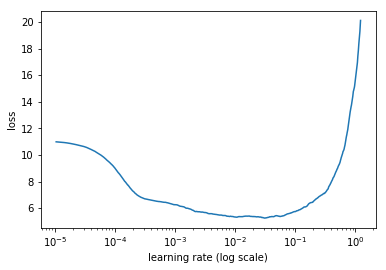

In [40]:
learner.lr_find()
learner.sched.plot()

In [43]:
lr = 1e-4
lrs = lr

In [44]:
learner.fit(lr/2, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

  0%|          | 17/3473 [00:05<16:58,  3.39it/s, loss=11]
epoch      trn_loss   val_loss   accuracy                     
    0      6.551438   6.625412   0.065571  



[array([ 6.62541]), 0.065570666585178253]

In [45]:
learner.fit(lr/2, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      6.28648    6.233443   0.112386  



[array([ 6.23344]), 0.11238561864428796]

In [46]:
len(train_text)

143613

In [49]:
learner.unfreeze()

In [50]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

 65%|██████▍   | 2244/3473 [13:00<07:07,  2.87it/s, loss=4.87]

KeyboardInterrupt: 

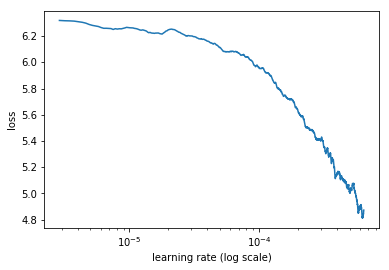

In [51]:
learner.sched.plot()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20, 10), cycle_len=2)

## Classifier Model

In [ ]:
wd = 1e-7
bptt = 70
bs = 52
opt_fn = pratial(optim.Adam, betas=(.8, .99))

In [ ]:
trn_comments = np.matrix(full_text)
trn_labels = np.matrix(labels)

In [ ]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c = int(trn_labels.max()) + 1

In [ ]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [ ]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [ ]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])